In [1]:
import numpy as np
import pandas as pd
from scipy import stats

import warnings
warnings.filterwarnings(action='ignore')

import folium
KC_coord = (47.4081,-121.9949)
Seattle_coord = (47.6062,-122.3321)
import matplotlib.pyplot as plt
from matplotlib import ticker
%matplotlib inline
import seaborn as sns

import statsmodels.api as sm
from statsmodels.api import OLS

In [2]:
# initialize dataframe
kc_house = pd.read_csv('./data/kc_house_data.csv', parse_dates=['date']) 

In [3]:
# check first 5 rows
kc_house.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,2014-10-13,221900.0,3,1.00,1180,5650,1.0,NaN,NONE,...,7 Average,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,2014-12-09,538000.0,3,2.25,2570,7242,2.0,NO,NONE,...,7 Average,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2015-02-25,180000.0,2,1.00,770,10000,1.0,NO,NONE,...,6 Low Average,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,2014-12-09,604000.0,4,3.00,1960,5000,1.0,NO,NONE,...,7 Average,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2015-02-18,510000.0,3,2.00,1680,8080,1.0,NO,NONE,...,8 Good,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [4]:
# check for columns/datatypes
kc_house.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   id             21597 non-null  int64         
 1   date           21597 non-null  datetime64[ns]
 2   price          21597 non-null  float64       
 3   bedrooms       21597 non-null  int64         
 4   bathrooms      21597 non-null  float64       
 5   sqft_living    21597 non-null  int64         
 6   sqft_lot       21597 non-null  int64         
 7   floors         21597 non-null  float64       
 8   waterfront     19221 non-null  object        
 9   view           21534 non-null  object        
 10  condition      21597 non-null  object        
 11  grade          21597 non-null  object        
 12  sqft_above     21597 non-null  int64         
 13  sqft_basement  21597 non-null  object        
 14  yr_built       21597 non-null  int64         
 15  yr_renovated   1775

__Objects__: 'waterfront', 'view', 'condition', 'grade', 'sqft_basement' - 'sqft_basement' seems like it should be numeric based on the data from the head, while the others may need to be transformed later to categorical variables

### Duplicates

In [5]:
# check for duplicate ids
kc_house['id'].duplicated().sum()

177

In [6]:
# drop duplicates, keeping first
kc_house = kc_house.sort_values('id', ascending = False).drop_duplicates(subset = 'id', keep = 'first')

In [7]:
# check duplicate count
kc_house['id'].duplicated().sum()

0

In [8]:
# drop 'id' - no longer useful as we have handled duplicate values
kc_house = kc_house.drop('id', axis=1)

### Nulls

In [9]:
# check null values
kc_house.isnull().sum()

date                0
price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront       2351
view               63
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated     3807
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
dtype: int64

#### waterfront

In [10]:
kc_house['waterfront'].value_counts()

NO     18923
YES      146
Name: waterfront, dtype: int64

In [11]:
# fill nulls with 0 or NO as the overwhelming majority of the sample is NO
kc_house['waterfront'] = kc_house['waterfront'].fillna(0)

#### view

In [12]:
kc_house['view'].value_counts()

NONE         19253
AVERAGE        956
GOOD           505
FAIR           329
EXCELLENT      314
Name: view, dtype: int64

In [13]:
# vast majority of data set has no view, better to drop as it will not provide meaningful insight for our model
kc_house.drop('view', axis = 1, inplace = True)

#### yr_renovated

In [14]:
kc_house['yr_renovated'].value_counts()

0.0       16873
2014.0       73
2003.0       31
2013.0       31
2007.0       30
          ...  
1948.0        1
1976.0        1
1951.0        1
1971.0        1
1944.0        1
Name: yr_renovated, Length: 70, dtype: int64

In [15]:
# vast majority of data has 0, fill w/ 0
kc_house['yr_renovated'] = kc_house['yr_renovated'].fillna(0)

In [16]:
# Final check for null values
kc_house.isna().sum()

date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

### Datatypes

In [17]:
# values of sqft_basement
kc_house['sqft_basement'].value_counts()

0.0      12717
?          452
600.0      216
500.0      206
700.0      205
         ...  
588.0        1
283.0        1
10.0         1
915.0        1
506.0        1
Name: sqft_basement, Length: 304, dtype: int64

In [18]:
# sqft_basement should be able to be calculated by taking sqft_living (overall) - sqft_above (only above basement)
# we should replace missing values of sqft_basement with these calculated values
for index in list(kc_house[kc_house['sqft_basement'] == '?'].index.values):
    kc_house.loc[index, 'sqft_basement'] = kc_house.loc[index, 'sqft_living'] - kc_house.loc[index, 'sqft_above']

In [37]:
# verify that there are no more sqft_basement values '?'
kc_house[kc_house['sqft_basement'] == '?']

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15


In [45]:
# cast as float
kc_house['sqft_basement'] = kc_house['sqft_basement'].astype(float)

In [47]:
#verify
kc_house.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21420 entries, 15937 to 2495
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          21420 non-null  float64
 1   bedrooms       21420 non-null  int64  
 2   bathrooms      21420 non-null  float64
 3   sqft_living    21420 non-null  int64  
 4   sqft_lot       21420 non-null  int64  
 5   floors         21420 non-null  float64
 6   waterfront     19069 non-null  float64
 7   condition      21420 non-null  int64  
 8   grade          21420 non-null  int64  
 9   sqft_above     21420 non-null  int64  
 10  sqft_basement  21420 non-null  float64
 11  yr_built       21420 non-null  int64  
 12  yr_renovated   21420 non-null  float64
 13  zipcode        21420 non-null  int64  
 14  lat            21420 non-null  float64
 15  long           21420 non-null  float64
 16  sqft_living15  21420 non-null  int64  
 17  sqft_lot15     21420 non-null  int64  
dtypes: 

### Remaining Extraneous Columns

In [20]:
# date is not relevant to our analysis
kc_house.drop('date',axis=1,inplace=True)

### Categorical Variables

In [21]:
kc_house.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
15937,268950.0,3,1.00,1320,8100,1.0,NO,Average,6 Low Average,880,440.0,1943,0.0,98166,47.4697,-122.351,1000,8100
20963,399900.0,2,1.75,1410,1005,1.5,NO,Average,9 Better,900,510.0,2011,0.0,98027,47.5446,-122.018,1440,1188
7614,339000.0,3,1.00,1100,4128,1.0,NO,Good,7 Average,720,380.0,1942,0.0,98126,47.5296,-122.379,1510,4538
3257,380000.0,2,1.00,1040,7372,1.0,NO,Very Good,7 Average,840,200.0,1939,0.0,98126,47.5285,-122.378,1930,5150
16723,365000.0,5,2.00,1600,4168,1.5,NO,Average,7 Average,1600,0.0,1927,0.0,98126,47.5297,-122.381,1190,4168


#### waterfront

In [22]:
kc_house['condition'].value_counts()

Average      13900
Good          5643
Very Good     1687
Fair           162
Poor            28
Name: condition, dtype: int64

In [23]:
# map 1 to YES and 0 to NO
waterfront_dict = {'YES':1, 'NO':0}
kc_house['waterfront'] = kc_house['waterfront'].map(waterfront_dict)

In [24]:
kc_house['waterfront'].value_counts()

0.0    18923
1.0      146
Name: waterfront, dtype: int64

#### condition

In [25]:
kc_house['condition'].value_counts()

Average      13900
Good          5643
Very Good     1687
Fair           162
Poor            28
Name: condition, dtype: int64

In [26]:
condition_dict = {'Very Good': 5, 'Good': 4, 'Average': 3, 'Fair': 2, 'Poor': 1}
kc_house['condition'] = kc_house['condition'].map(condition_dict)

In [27]:
kc_house['condition'].value_counts()

3    13900
4     5643
5     1687
2      162
1       28
Name: condition, dtype: int64

#### grade 

In [31]:
kc_house['grade'].value_counts()

7 Average        8889
8 Good           6041
9 Better         2606
6 Low Average    1995
10 Very Good     1130
11 Excellent      396
5 Fair            234
12 Luxury          88
4 Low              27
13 Mansion         13
3 Poor              1
Name: grade, dtype: int64

In [33]:
grade_dict = {'13 Mansion':10, '12 Luxury':9, '11 Excellent':8, '10 Very Good':7, '9 Better': 6, '8 Good': 5, 
              '7 Average': 4, '5 Fair': 3, '6 Low Average': 2, '4 Low': 1, '3 Poor': 0}
kc_house['grade'] = kc_house['grade'].map(grade_dict)

In [34]:
kc_house['grade'].value_counts()

4     8889
5     6041
6     2606
2     1995
7     1130
8      396
3      234
9       88
1       27
10      13
0        1
Name: grade, dtype: int64

In [36]:
kc_house.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21420 entries, 15937 to 2495
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          21420 non-null  float64
 1   bedrooms       21420 non-null  int64  
 2   bathrooms      21420 non-null  float64
 3   sqft_living    21420 non-null  int64  
 4   sqft_lot       21420 non-null  int64  
 5   floors         21420 non-null  float64
 6   waterfront     19069 non-null  float64
 7   condition      21420 non-null  int64  
 8   grade          21420 non-null  int64  
 9   sqft_above     21420 non-null  int64  
 10  sqft_basement  21420 non-null  object 
 11  yr_built       21420 non-null  int64  
 12  yr_renovated   21420 non-null  float64
 13  zipcode        21420 non-null  int64  
 14  lat            21420 non-null  float64
 15  long           21420 non-null  float64
 16  sqft_living15  21420 non-null  int64  
 17  sqft_lot15     21420 non-null  int64  
dtypes: 

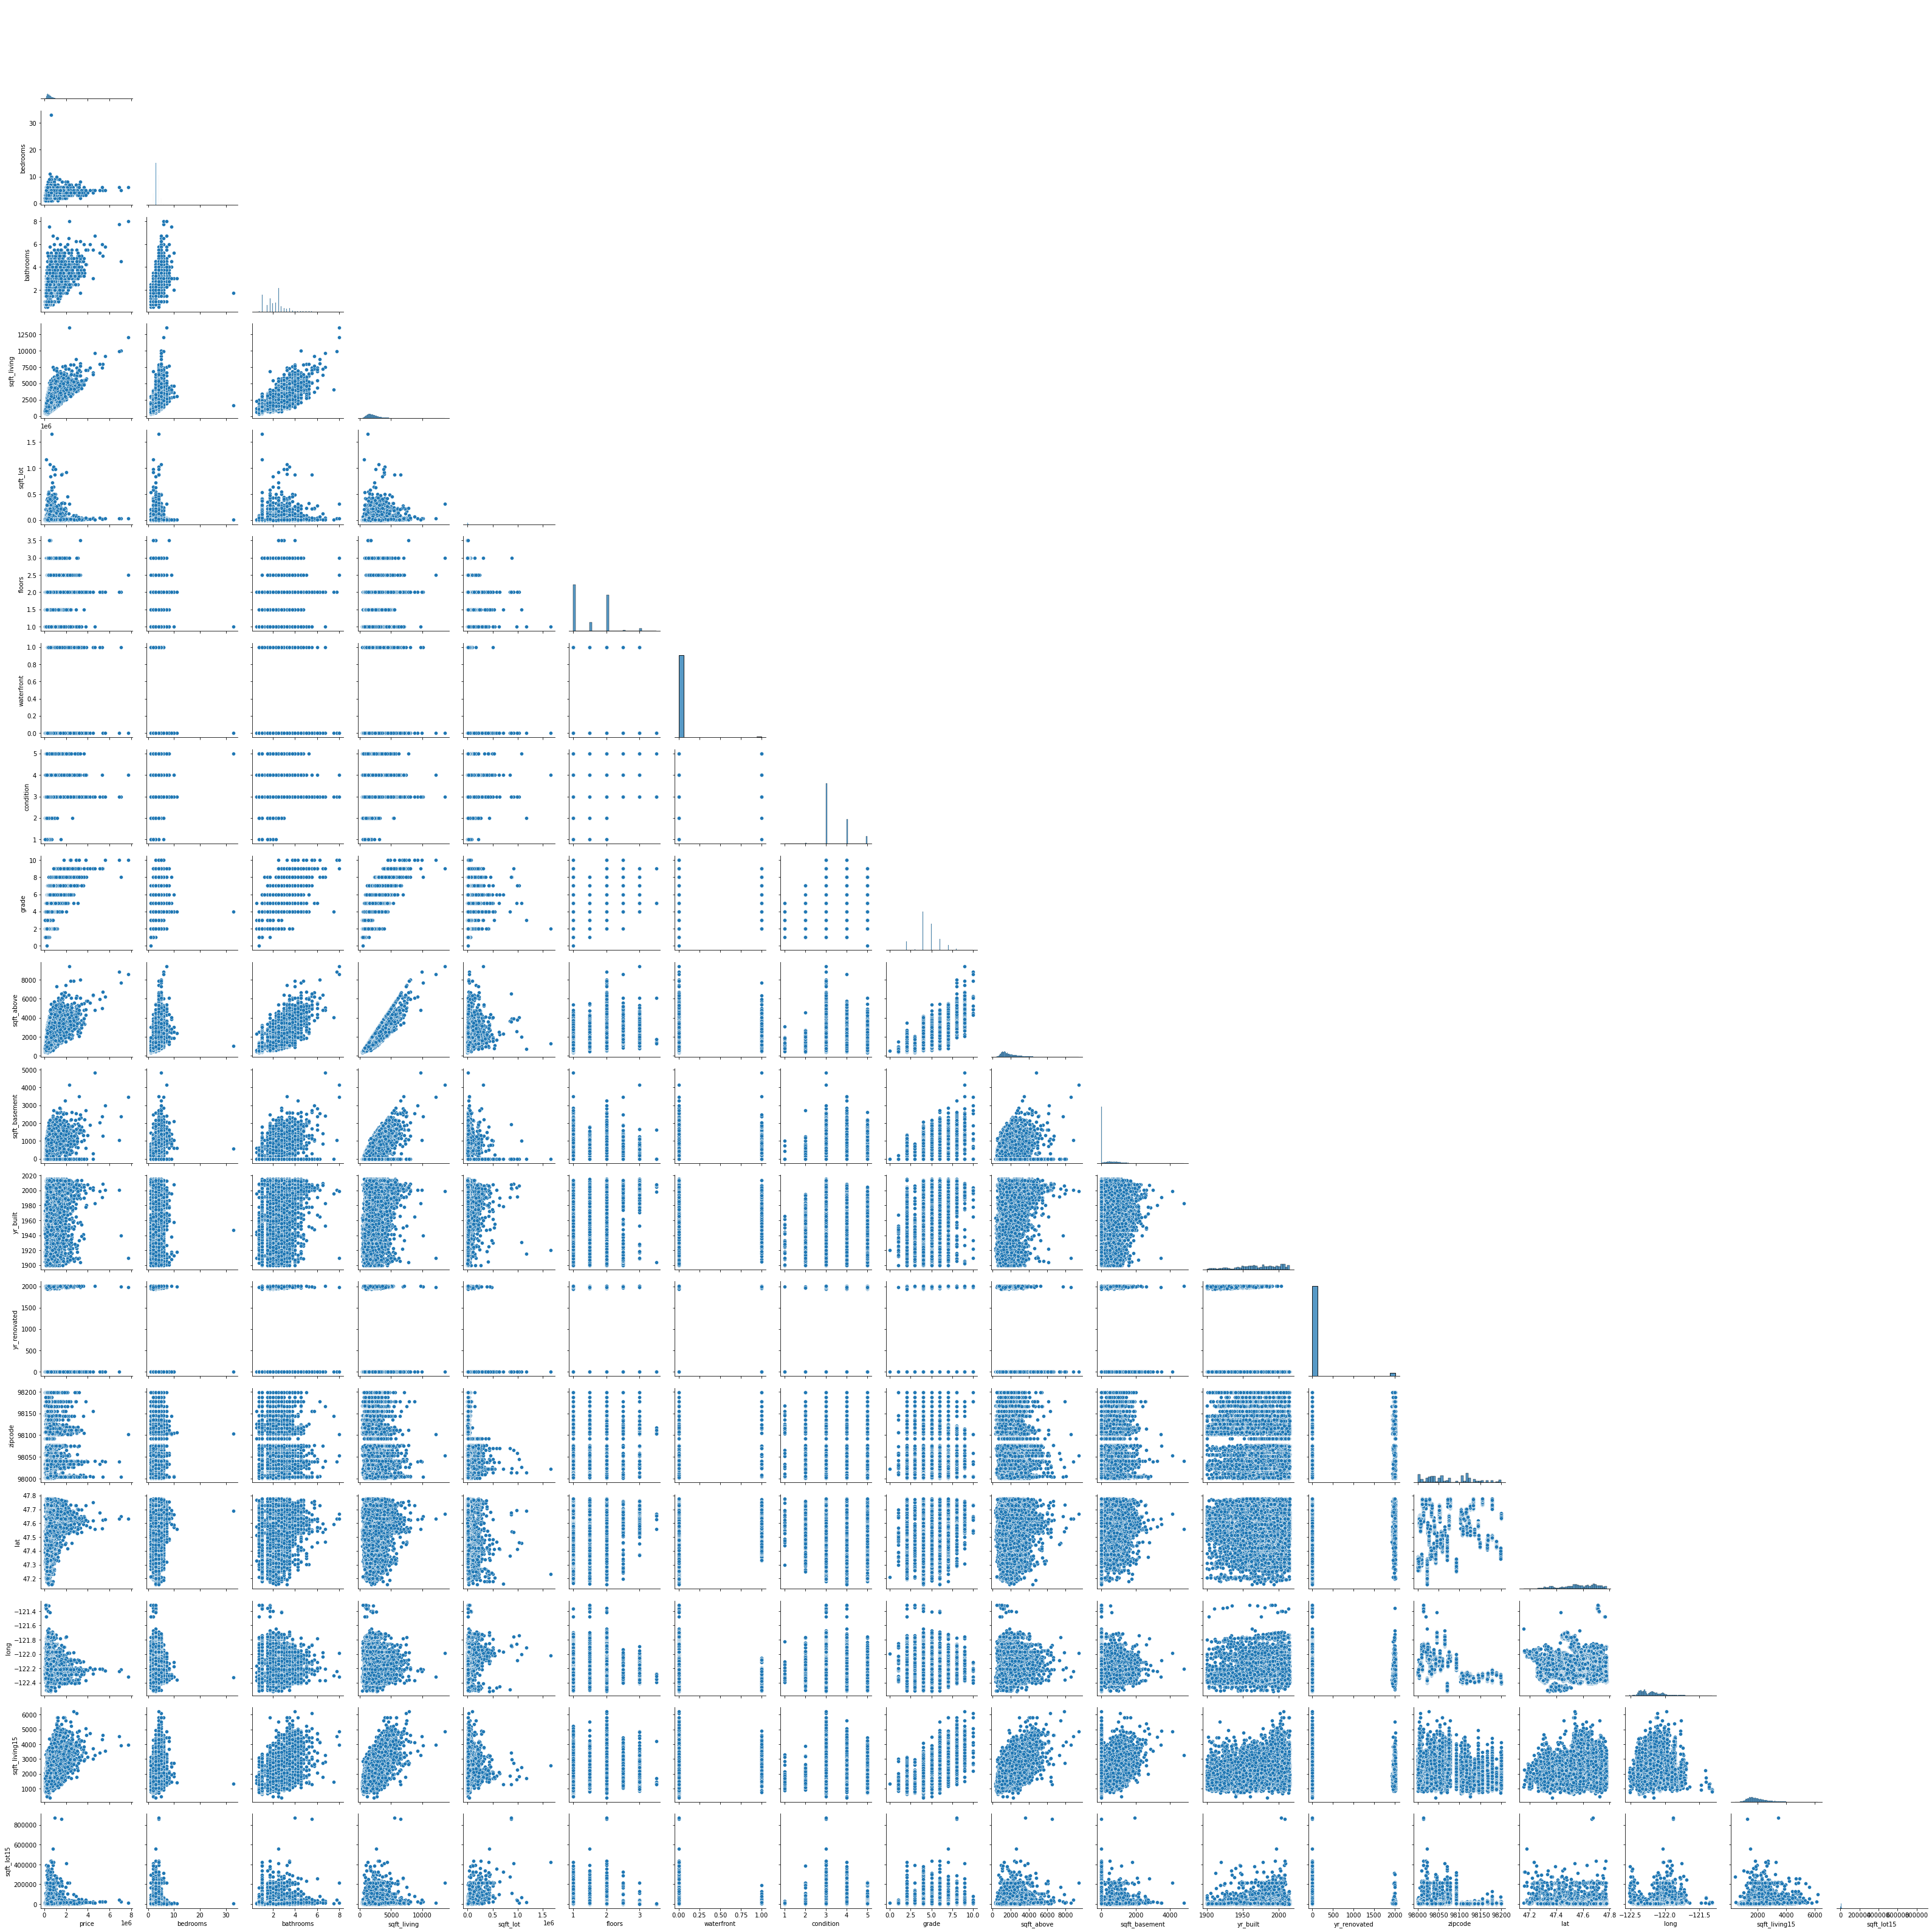

In [49]:
# pairplot for quick check
sns.pairplot(kc_house, diag_kind = 'hist', corner = True)

In [50]:
kc_house.corr()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
price,1.000000,0.309665,0.525859,0.701651,0.088936,0.255711,0.276894,0.034560,0.635260,0.604916,0.323777,0.051940,0.118336,-0.051808,0.306024,0.020368,0.584227,0.082247
bedrooms,0.309665,1.000000,0.515383,0.579069,0.032490,0.177734,-0.002491,0.025893,0.364103,0.480242,0.302748,0.155241,0.017470,-0.155061,-0.011266,0.132439,0.394949,0.030570
bathrooms,0.525859,0.515383,1.000000,0.755522,0.087779,0.501803,0.067286,-0.129362,0.664261,0.686328,0.283205,0.506252,0.047686,-0.203884,0.023143,0.223808,0.569453,0.087760
sqft_living,0.701651,0.579069,0.755522,1.000000,0.172586,0.352868,0.110318,-0.061677,0.739845,0.876533,0.434505,0.316646,0.050851,-0.198995,0.050739,0.240212,0.756186,0.183837
sqft_lot,0.088936,0.032490,0.087779,0.172586,1.000000,-0.005561,0.023091,-0.009169,0.107510,0.183210,0.015239,0.052312,0.004991,-0.129422,-0.085822,0.230265,0.143805,0.717743
floors,0.255711,0.177734,0.501803,0.352868,-0.005561,1.000000,0.021648,-0.266859,0.453696,0.522751,-0.246078,0.488935,0.003141,-0.058532,0.048900,0.124812,0.279071,-0.011367
waterfront,0.276894,-0.002491,0.067286,0.110318,0.023091,0.021648,1.000000,0.017593,0.080885,0.075410,0.088154,-0.026455,0.079376,0.031367,-0.012842,-0.040156,0.088932,0.031944
condition,0.034560,0.025893,-0.129362,-0.061677,-0.009169,-0.266859,0.017593,1.000000,-0.147844,-0.161483,0.174204,-0.365129,-0.056264,0.004372,-0.015566,-0.107154,-0.095256,-0.003450
grade,0.635260,0.364103,0.664261,0.739845,0.107510,0.453696,0.080885,-0.147844,1.000000,0.728801,0.171207,0.457532,0.012923,-0.196204,0.110639,0.202523,0.691557,0.112703
sqft_above,0.604916,0.480242,0.686328,0.876533,0.183210,0.522751,0.075410,-0.161483,0.728801,1.000000,-0.052672,0.422977,0.020078,-0.260803,-0.002040,0.344161,0.731887,0.194445


In [52]:
kc_house.corr()['price'].abs().sort_values(ascending=False)

price            1.000000
sqft_living      0.701651
grade            0.635260
sqft_above       0.604916
sqft_living15    0.584227
bathrooms        0.525859
sqft_basement    0.323777
bedrooms         0.309665
lat              0.306024
waterfront       0.276894
floors           0.255711
yr_renovated     0.118336
sqft_lot         0.088936
sqft_lot15       0.082247
yr_built         0.051940
zipcode          0.051808
condition        0.034560
long             0.020368
Name: price, dtype: float64